In [1]:
# for Python2 and Python3 bridging
# from __future__ import absolute_import, division, print_function
import codecs
import glob
import multiprocessing
import pprint
import re
import nltk
# import logging

In [2]:
import gensim.models.word2vec as w2v
# reduce dimenisonality
# import sklearn.manifold  # original 1 core TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib notebook

from nltk.corpus import stopwords


In [143]:
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# data cleaning
nltk.download('punkt') # tokenizer
nltk.download('stopwords')

In [3]:
stop_words = set(stopwords.words('english'))

In [4]:
books = sorted(glob.glob("game_of_thrones_data/*.txt"))


In [5]:
raw_corpus = u""
for book in books:
    with codecs.open(book, "r", "utf-8") as book_file:
        print("reading {0} book and adding it to the corpus".format(book))
        raw_corpus += (book_file.read())
        print("corpus is {0} characters long now".format(len(raw_corpus)))

reading game_of_thrones_data/got1.txt book and adding it to the corpus
corpus is 1770658 characters long now
reading game_of_thrones_data/got2.txt book and adding it to the corpus
corpus is 4071039 characters long now
reading game_of_thrones_data/got3.txt book and adding it to the corpus
corpus is 6391402 characters long now
reading game_of_thrones_data/got4.txt book and adding it to the corpus
corpus is 8107941 characters long now
reading game_of_thrones_data/got5.txt book and adding it to the corpus
corpus is 9719480 characters long now


In [6]:
tokenizer = nltk.data.load("/home/jinam/nltk_data/tokenizers/punkt/english.pickle")

In [7]:
# change to spacy/ner for better accuracy
raw_sentences = tokenizer.tokenize(raw_corpus)
print(len(raw_sentences),  " number of sentences are in the corpus") 

128868  number of sentences are in the corpus


In [8]:
# remove numbers and other characters and split sentences to words
# gives clean words from unclean sentences
def sentence_to_wordslist(raw_sentence):
    clean_sentence = re.sub("[^a-zA-Z]", " ", raw_sentence)
    words = clean_sentence.split()
    words = [w for w in words if w not in stop_words]
    return words
        

In [9]:
# clean_sentences: [[words for a sentence], [words for another sentence], ...]
clean_sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        clean_sentences.append(sentence_to_wordslist(raw_sentence))


In [10]:
total_tokens = sum([len(clean_sentence) for clean_sentence in clean_sentences])
print("There are",total_tokens,"number of tokens in the corpus")

There are 1034185 number of tokens in the corpus


# TRAINING

In [11]:
# Vectors help with distance, similairty, ranking


# dimensionality of resulting vectors: higher -> more computationally expensive, more accurate, more generalized
#                                      lower  -> less expensive, less accurate, less generalized
num_features = 300

# minimum threshold: the sentence should have x words to be considered for training
min_word_count = 10

# number of workers/threads to run
num_workers = multiprocessing.cpu_count()


# context window size: n-gram ()
context_size = 5

# downsampling for frequent words
downsampling = 1e-3

# seed allows random number generation
# deterministic, good for debugging
seed = 0

In [12]:
# building model
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers = num_workers,
    size = num_features,
    min_count = min_word_count,
    window = context_size,
    sample = downsampling
)

In [15]:
thrones2vec.build_vocab(clean_sentences)

RuntimeError: cannot sort vocabulary after model weights already initialized.

In [14]:
len(thrones2vec.wv.vocab)

8931

In [16]:
# epochs indirectly proportionate to vocab size, around 100
thrones2vec.train(clean_sentences,total_words= total_tokens, epochs = 50,compute_loss= True)

(45897125, 51709250)

In [61]:
thrones2vec.get_latest_training_loss()

34770636.0

In [36]:
thrones2vec.train(clean_sentences,total_words= total_tokens, epochs = 10,compute_loss= True)

(9616080, 10341850)

In [151]:
thrones2vec.save("thrones2vec_100iter.w2v")

2019-04-08 16:37:25,518 : INFO : saving Word2Vec object under thrones2vec_100iter.w2v, separately None
2019-04-08 16:37:25,521 : INFO : not storing attribute vectors_norm
2019-04-08 16:37:25,525 : INFO : not storing attribute cum_table
2019-04-08 16:37:25,884 : INFO : saved thrones2vec_100iter.w2v


In [ ]:
class EpochSaver(CallbackAny2Vec):
'''Callback to save model after each epoch and show training parameters '''

def __init__(self, savedir):
    self.savedir = savedir
    self.epoch = 0

    os.makedirs(self.savedir, exist_ok=True)

def on_epoch_end(self, model):
    savepath = os.path.join(self.savedir, "model_neg{}_epoch.gz".format(self.epoch))
    model.save(savepath)
    print(
        "Epoch saved: {}".format(self.epoch + 1),
        "Start next epoch ... ", sep="\n"
        )
    if os.path.isfile(os.path.join(self.savedir, "model_neg{}_epoch.gz".format(self.epoch - 1))):
        print("Previous model deleted ")
        os.remove(os.path.join(self.savedir, "model_neg{}_epoch.gz".format(self.epoch - 1))) 
    self.epoch += 1
    print("Model loss:", model.get_latest_training_loss())

def train():

    ### Initialize model ###
    print("Start training Word2Vec model")

    workers = multiprocessing.cpu_count()

    model = Word2Vec(
        DocIter(),
        size=300, alpha=0.03, min_alpha=0.00025, iter=20,
        min_count=10, hs=0, negative=10, workers=workers,
        window=10, callbacks=[EpochSaver("./checkpoints")], 
        compute_loss=True
)  

# EXPLORATION

In [63]:
thrones2vec = w2v.Word2Vec.load("thrones2vec_100iter.w2v")

In [64]:
# tsne = sklearn.manifold.TSNE(n_components=2, random_state=0) # 300 dimensions to 2 dimenstions
tsne = TSNE(n_jobs=8, n_components= 2)

In [65]:
all_words_vectors_matrix = thrones2vec.wv.syn0

/home/jinam/_p/python-environments/genuse/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [66]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_words_vectors_matrix)

In [67]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [68]:
points.head()

,word,x,y
0,This,-1.551484,0.596670
1,edition,8.248496,0.476588
2,complete,8.085578,0.067837
3,original,8.121909,0.271633
4,hardcover,8.178006,0.399899


In [69]:
sns.set_context("poster")

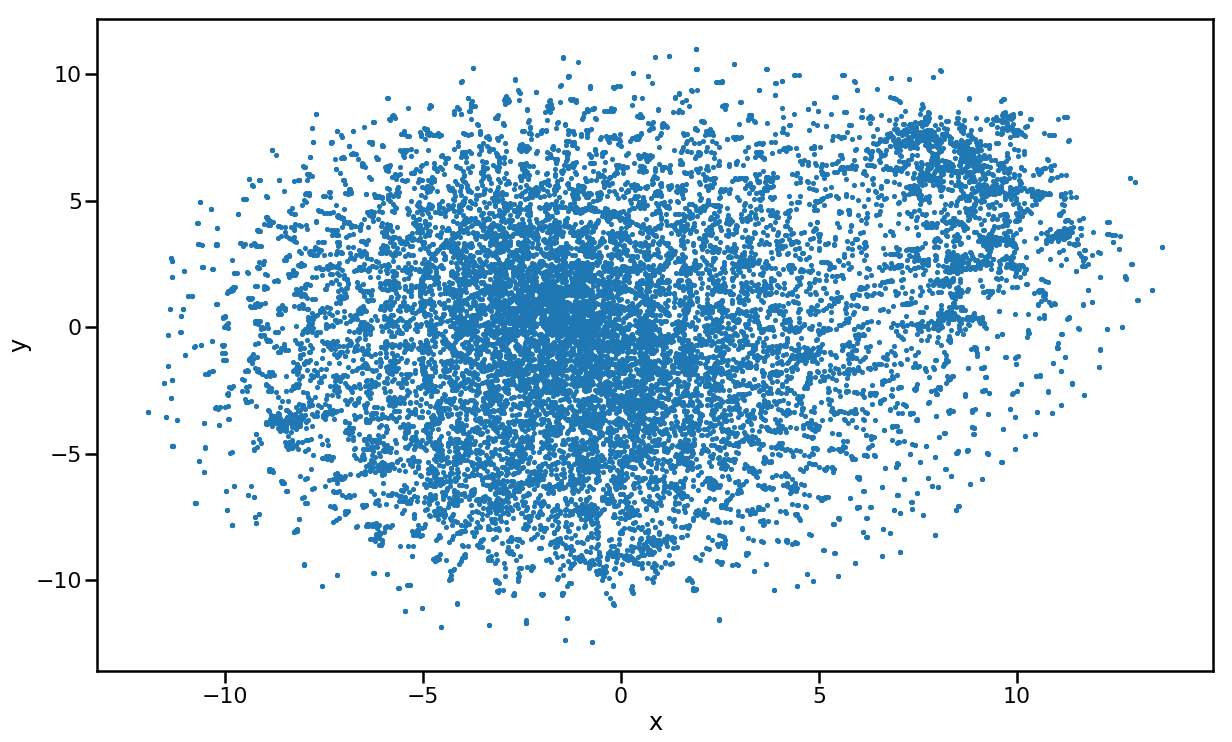

In [70]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [76]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

AxesSubplot(0.125,0.125;0.775x0.755)


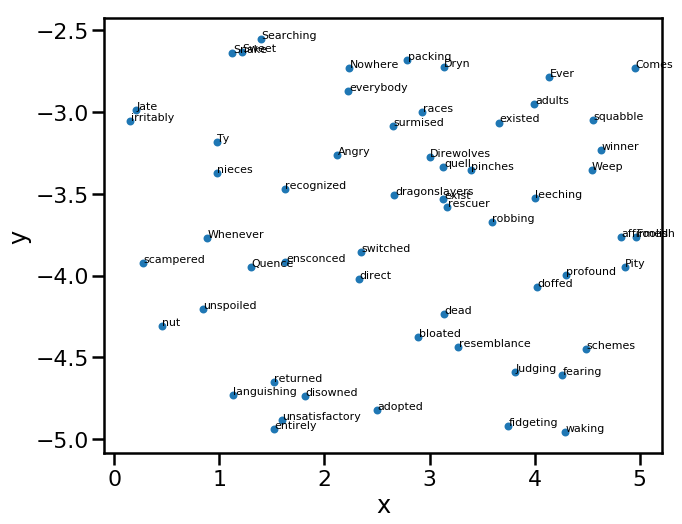

In [90]:
plot_region(x_bounds=(-0,5), y_bounds=(-5, -2.5))

In [59]:
thrones2vec.wv.most_similar("Stark")

[('Eddard', 0.6770813465118408),
 ('executed', 0.5642762184143066),
 ('beheaded', 0.532862663269043),
 ('fishwife', 0.530762255191803),
 ('Edrick', 0.5237277746200562),
 ('Snowbeard', 0.5217519998550415),
 ('absently', 0.5207921266555786),
 ('Karstark', 0.5140361189842224),
 ('Lyanna', 0.5127736330032349),
 ('North', 0.5124740600585938)]

In [114]:
thrones2vec.wv.most_similar("Daenerys")

[('Stormborn', 0.635555624961853),
 ('Targaryen', 0.6004083156585693),
 ('Unburnt', 0.5706058740615845),
 ('khaleesi', 0.5380901098251343),
 ('quicken', 0.5278524160385132),
 ('dosh', 0.4783553183078766),
 ('Khaleesi', 0.47470754384994507),
 ('consented', 0.4743860960006714),
 ('Rhaggat', 0.47254785895347595),
 ('barbaric', 0.4680108428001404)]

In [73]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [74]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")


Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as drained is related to wine
Arya is related to Nymeria, as Harrenhal is related to dragons


/home/jinam/_p/python-environments/genuse/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


'Harrenhal'